# IMPORTS

In [1]:
from os import listdir,mkdir,makedirs
from os.path import isfile, join, isdir,exists
import pandas as pd
import numpy as np
from scipy import stats
import re
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from myplots import roundup, rounddown, find_decimal_fold, percentile_cut_off, rarefaction_calc, rarefaction_plot,draw_correlation_scatter
from matplotlib.ticker import FormatStrFormatter
import cPickle as pickle
from Bio.SeqUtils import GC
import seaborn as sns
import random
from scipy.stats import pearsonr,fisher_exact
from skbio.diversity.alpha import shannon, simpson, berger_parker_d

from pop_organize import get_sample_data, get_sample_with_dfs
from SufficientStatistics import *
from MyFunctionsShani import *
import math
from myplots import roundup, rounddown, find_decimal_fold
from skbio.stats.distance import mantel
from scipy.spatial.distance import braycurtis, pdist
from GeneralFeaturePhenotypeInteractions.Feature_phenotype_functions import * 
from TCR_microbiome_interactions.TCR_microbiome_interactions_functions import *
from SampleLists.SampleFileFunctions import *

import os
from Utils import cacheOnDisk
from queue.qp import qp,fakeqp
from addloglevels import sethandlers

MyPath='/net/mraid08/export/genie/Lab/Personal/ShaniBAF'

done1
stop
stop
done1
stop
done
done


In [2]:
import time
cdate=str(time.strftime("%d%m%Y"))
cdate


'16052018'

# plan


#some ideas and code are taken from notebook: 'Feature-Phenotype interactions in the PNP cohort-2-Copy1'


1. load TCR sharing matrix - take subset according to threshold
2. load Mb table  - take subset according to the same threshold
3. filter same sample, outliers-yes/no
3. calculate features per sample:
n common seqs/species, mean RA, top RA, shannon, simpson, berger
4. calculate correlations between parameters within dataset
5. calculate correlations between parameters between TCR and Mb
6. calculate distance matrix for TCR and Mb and correlate (braycurtis, euclidean, jaccard)

# TCR-Mb repertoire diversity correlations - devlope

### load and prepare Mb file:

In [ ]:
print 'loading most updated Mb file...'
f1 = '%s/MicrobiomeDataTables/FilteredAndMergedOnBD/MPA_s_AllSeqProjects_SampleListPNP515_filterGenotekTrue_filterMinimalRead9000000_meannSTDNonenMinSamplesNone_filterOutlierSampleFalse_filterSamePersonFalse' % MyPath
groupedFilteredMB = pd.read_pickle(f1)
filterGenotek = True
filterMinimalReads = 9000000

MbDFName = 'Mb_Swabs%sMinReads%s' % (filterGenotek, filterMinimalReads)

In [ ]:
groupedFilteredMB.head()

In [ ]:
# prepare MB file:
# load BD_FD converter, to make sure we remove BD_FD columns from the MB file:
f1 = '%s/Sample files/updatedBDandFDlists/final_BD_FD_converter_mergedOnYear_RCfolderAllSeqProjects_17042018' % MyPath
BD_FD = pd.read_pickle(f1)

try:
    MbDF_RA = groupedFilteredMB.set_index('BD')  #### very important!!
except KeyError:
    print 'couldnt reset index to BD,probably BD is already the index'
    MbDF_RA = groupedFilteredMB


# remove unnecessary columns:
for column in BD_FD.columns.values:
    if column in MbDF_RA.columns.values:
        print 'dropping %s column' % column
        MbDF_RA = MbDF_RA.drop(column, axis=1)

### loading and preparing TCR file

In [ ]:
datasetFolder='%s/TCR_real_data/SubSampled15000data_rep2' %MyPath
datasetName='PNP515_ss15000_rep2'

minNshared = 50  # add to function variables if necessary
file1 = '%s/sharingAnalysis/sharingMatrix_%s_minNshared%s_RA' % (datasetFolder, datasetName, minNshared)
TCRdf_RA = pd.read_pickle(file1)

TCRdfName = 'TCRminNshared%s' % minNshared

### define cutoffs for TCR and Mb matrix:

In [ ]:
thresholdList=[(None,None,50,50)]
outlierSTD=3

for t in thresholdList:
        NsharedSamplesForSpecies = t[0]
        NsharedSamplesForSeqs = t[1]
        topNspecies = t[2]
        topNseqs = t[3]
        print 'threshold parameters are:'
        print NsharedSamplesForSpecies, NsharedSamplesForSeqs, topNspecies, topNseqs

### prepare TCR and Mb tables according to the cutoffs:

*get only relevant sequences and species according to the thresholds
*remove same person
*merge table and ensure the same samples appear in both tables, in the same order
*filter outliers

In [ ]:
species_sequences_df, speciesList, sequenceList=prepare_MbDF_and_TCRdf_for_analysis(MbDF_RA, MbDFName, TCRdf_RA, TCRdfName, NsharedSamplesForSpecies, NsharedSamplesForSeqs,
                                          topNspecies, topNseqs)

In [ ]:
print len(species_sequences_df)
if outlierSTD is not None:
    print 'filtering outliers...'
    species_sequences_df_filtered = filter_outliers(df=species_sequences_df, 
                                    outlierSTD=outlierSTD, columnList=species_sequences_df.columns.values)
else:
    species_sequences_df_filtered=species_sequences_df
print len(species_sequences_df_filtered)  

In [ ]:
# get seperate Mb table:
species_df=species_sequences_df_filtered[speciesList]
print species_df.shape
print species_df.index[:5]
print species_df.index[-5:]
# print species_df.head()


In [ ]:
# get seperate TCR table:
seq_df=species_sequences_df_filtered[sequenceList]
print seq_df.shape
print seq_df.index[:5]
print seq_df.index[-5:]
# print species_df.head()

### calculate features for both dfs:
n common seqs/species, mean RA, top RA, shannon, simpson, berger


In [ ]:
seqFeatureDF=calc_diversity_features_for_public_matrix(seq_df)

In [ ]:
speciesFeatureDF=calc_diversity_features_for_public_matrix(species_df)

### calculate correlations between TCR and Mb:

In [ ]:
for column in seqFeatureDF.columns:
    r,p=MyPearsonr(seqFeatureDF[column],speciesFeatureDF[column])
    print column,r,p

### define functions:

In [ ]:
def calc_diversity_features_for_public_matrix(df):
#     print 'calculate diversity features for df...'
    featureDF=pd.DataFrame(index=df.index)
    featureDF['nCom']=df.apply(lambda x: len([i for i in x if i>0]),axis=1)
    featureDF['meanRA']=df.apply(np.mean,axis=1)
    featureDF['maxRA']=df.apply(np.max,axis=1)
    featureDF['simpson']=df.apply(lambda x: simpson([int(i*1000) for i in x if not np.isnan(i)]),axis=1)
    featureDF['berger_parker_d']=df.apply(lambda x: berger_parker_d([int(i*1000) for i in x if not np.isnan(i)]),axis=1)
    featureDF['shannon']=df.apply(lambda x: shannon([int(i*1000) for i in x if not np.isnan(i)],base=2),axis=1)
#     print featureDF.head()
    
    print 'calculate features correlations...'
    for i in range(len(featureDF.columns)):
        for j in range(i+1,len(featureDF.columns)):
            column1=featureDF.columns[i]
            column2=featureDF.columns[j]
            r,p=MyPearsonr(featureDF[column1],featureDF[column2])
#             print column1, column2, r,p
            
    return featureDF

In [ ]:
def calc_diversity_correlations_TCR_Mb(datasetFolder,MbDF_RA,MbDFName,TCRdf_RA,TCRdfName,thresholdList,
                                      outlierSTD,minNshared):
    
    #(1) prepare MB file:
    # load BD_FD converter, to make sure we remove BD_FD columns from the MB file:
    f1 = '%s/Sample files/updatedBDandFDlists/final_BD_FD_converter_mergedOnYear_RCfolderAllSeqProjects_17042018' % MyPath
    BD_FD = pd.read_pickle(f1)

    try:
        MbDF_RA = MbDF_RA.set_index('BD')  #### very important!!
    except KeyError:
        print 'couldnt reset index to BD,probably BD is already the index'
        MbDF_RA = MbDF_RA


    # remove unnecessary columns:
    for column in BD_FD.columns.values:
        if column in MbDF_RA.columns.values:
            print 'dropping %s column' % column
            MbDF_RA = MbDF_RA.drop(column, axis=1)
                                       
    ### (2) define cutoffs for TCR and Mb matrix:
    for t in thresholdList:
        NsharedSamplesForSpecies = t[0]
        NsharedSamplesForSeqs = t[1]
        topNspecies = t[2]
        topNseqs = t[3]
        print 'threshold parameters are:'
        print NsharedSamplesForSpecies, NsharedSamplesForSeqs, topNspecies, topNseqs
    
        ### (3) prepare TCR and Mb tables according to the cutoffs:
        species_sequences_df, speciesList, sequenceList=prepare_MbDF_and_TCRdf_for_analysis(MbDF_RA, MbDFName, TCRdf_RA, TCRdfName, NsharedSamplesForSpecies, NsharedSamplesForSeqs,
                                              topNspecies, topNseqs)
        print 'species_sequences_df length is %s' %len(species_sequences_df)
        if outlierSTD is not None:
            print 'filtering outliers...'
            species_sequences_df_filtered = filter_outliers(df=species_sequences_df, 
                                            outlierSTD=outlierSTD, columnList=species_sequences_df.columns.values)
        else:
            species_sequences_df_filtered=species_sequences_df
        print 'species_sequences_df length is %s' %len(species_sequences_df_filtered)

        # get seperate Mb table:
        species_df=species_sequences_df_filtered[speciesList]
        print 'species_df shape is %s_%s' %(species_df.shape[0],species_df.shape[1])
    #     print species_df.index[:5]
    #     print species_df.index[-5:]
    #     # print species_df.head()

        # get seperate TCR table:
        seq_df=species_sequences_df_filtered[sequenceList]
        print 'seq_df shape is %s_%s' %(seq_df.shape[0],seq_df.shape[1])
    #     print seq_df.index[:5]
    #     print seq_df.index[-5:]
    #     # print species_df.head()

        ### (4) calculate features for both dfs:
        print 'calculating features for seqDF...'
        seqFeatureDF=calc_diversity_features_for_public_matrix(seq_df)
        print 'calculating features for speciesDF...'
        speciesFeatureDF=calc_diversity_features_for_public_matrix(species_df)

        ### (5) calculate correlations between TCR and Mb:
        print 'calculating correlation between TCR and MB...'
        divCorrTCR_MB=pd.DataFrame()
        for n,column in enumerate(seqFeatureDF.columns):
            r,p=MyPearsonr(seqFeatureDF[column],speciesFeatureDF[column])
            print column,r,p
            divCorrTCR_MB.loc[n,'column']=column
            divCorrTCR_MB.loc[n,'r']=r
            divCorrTCR_MB.loc[n,'p']=p

        ### save diversity correlation df....
        minP=round(divCorrTCR_MB['p'].min(),3)
        print 'the best p-value is %s' %minP
        print 'saving file...'
        parameters='t(%s%s%s%s)_std%s_minNshared%s' %(NsharedSamplesForSpecies, NsharedSamplesForSeqs, topNspecies, 
                                         topNseqs,outlierSTD,minNshared)
        folder='%s/TCR_mb_results/divCorrTCR_MB_dfs' %datasetFolder
        if not isdir(folder):
            makedirs(folder)
        file1='%s/divCorrTCR_MB_%s_minP%s.xlsx' %(folder,parameters,minP)
        divCorrTCR_MB.to_excel(file1)
                                       
    return divCorrTCR_MB
    

    
    

# TCR-Mb diversity correlation - run function

### try to run from .py

In [ ]:
stdList=[None]
thresholdList=[(None,None,50,50)]

datasetFolder='%s/TCR_real_data/SubSampled12500data_rep2' %MyPath
datasetName='PNP515_ss12500_rep2'

f1 = '%s/MicrobiomeDataTables/FilteredAndMergedOnBD/MPA_s_AllSeqProjects_SampleListPNP515_filterGenotekTrue_filterMinimalRead9000000_meannSTDNonenMinSamplesNone_filterOutlierSampleFalse_filterSamePersonFalse' % MyPath
MbDF_RA = pd.read_pickle(f1)
filterGenotek = True
filterMinimalReads = 9000000
MbDFName = 'Mb_Swabs%sMinReads%s' % (filterGenotek, filterMinimalReads)

minNshared = 50  # add to function variables if necessary
file1 = '%s/sharingAnalysis/sharingMatrix_%s_minNshared%s_RA' % (datasetFolder, datasetName, minNshared)
TCRdf_RA = pd.read_pickle(file1)
TCRdfName = 'TCRminNshared%s' % minNshared

for outlierSTD in stdList:
    print 'outlierSTD=%s' %outlierSTD
    divCorrTCR_MB=calc_diversity_correlations_TCR_Mb(datasetFolder,MbDF_RA,MbDFName,TCRdf_RA,
                                                 TCRdfName,thresholdList,outlierSTD,minNshared)

### datasetPNP515_ss18000_rep2
run from .py file:

In [ ]:

stdList=[None]
thresholdList=[(None,None,400,400),(None,None,1000,1000)]

datasetFolder='%s/TCR_real_data/SubSampled18000data_rep2' %MyPath
datasetName='PNP515_ss18000_rep2'

f1 = '%s/MicrobiomeDataTables/FilteredAndMergedOnBD/MPA_s_AllSeqProjects_SampleListPNP515_filterGenotekTrue_filterMinimalRead9000000_meannSTDNonenMinSamplesNone_filterOutlierSampleFalse_filterSamePersonFalse' % MyPath
MbDF_RA = pd.read_pickle(f1)
filterGenotek = True
filterMinimalReads = 9000000
MbDFName = 'Mb_Swabs%sMinReads%s' % (filterGenotek, filterMinimalReads)

minNshared = 2  # add to function variables if necessary
file1 = '%s/sharingAnalysis/sharingMatrix_%s_minNshared%s_RA' % (datasetFolder, datasetName, minNshared)
TCRdf_RA = pd.read_pickle(file1)
TCRdfName = 'TCRminNshared%s' % minNshared

for outlierSTD in stdList:
    print 'outlierSTD=%s' %outlierSTD
    divCorrTCR_MB=calc_diversity_correlations_TCR_Mb(datasetFolder,MbDF_RA,MbDFName,TCRdf_RA,
                                                 TCRdfName,thresholdList,outlierSTD,minNshared)

### run for all public seq and species:

main outline of the following code:
1. load TCRdf and MbDF with all common sequences and species (minNshared=2)
2. clean matrices - remove unnecssary columns, set sample names as index
3. if desired, zeros all RA values that are below 0.0001 (?)
4. equalzie the matrices so they will include the same samples, in the same order
5. calculates diversity and clonality features for each matrix
6. calculate correlation between the diversity features
7. plots the distributions and correlations of all diversity features.

NOTES:
files are saved! load instead of recalculating next time
option to plot all distributions first

#### load TCRdf and MbDF matrices that contains all seqs/species common to two samples or more:

In [3]:
#load files:
datasetFolder='%s/TCR_real_data/SubSampled15000data_rep2' %MyPath
datasetName='PNP515_ss15000_rep2'
minNshared=2
libPrepMethod=None


print 'loading TCRdf and MbDF files...'
#load files:
TCRdf_RA,TCRdf_binary=prepare_TCRdfRA_TCRdfbinary_for_distMat(datasetFolder,datasetName,minNshared)
MbDF_RA,MbDF_binary=prepare_MbDFRA_MbDFbinary_for_distMat(libPrepMethod)

TCRdf_RA=filterSamePerson(TCRdf_RA,[0])
MbDF_RA=filterSamePerson(MbDF_RA,[0])

loading TCRdf and MbDF files...
loading TCRdf_RA...
done...
loading TCRdf_binary...
done
checking for same-person pairs within the dataset:
number of samples in the dataset - 392
the sample pair BD617 and BD838 are in the dataset
only sample BD714 is in the dataset
loading MbDF_RA...
       Abiotrophia_defectiva  Acidaminococcus_fermentans  \
BD                                                         
BD1                      0.0                         0.0   
BD10                     0.0                         0.0   
BD101                    0.0                         0.0   
BD105                    0.0                         0.0   
BD106                    0.0                         0.0   

       Acidaminococcus_intestini  Acidaminococcus_sp_BV3L6  \
BD                                                           
BD1                          0.0                       0.0   
BD10                         0.0                       0.0   
BD101                        0.0              

#### re-calculate relative abundances to sum-up to 1

In [35]:
print TCRdf_RA.sum(axis=1)[:5]
TCRdf_RA_norm=TCRdf_RA.div(TCRdf_RA.sum(axis=1),axis=0)


print TCRdf_RA_norm.sum(axis=1)[:5]

BD
BD1      22.766667
BD10     26.080000
BD101    15.746667
BD105    23.473333
BD106    24.540000
dtype: float64
BD
BD1      1.0
BD10     1.0
BD101    1.0
BD105    1.0
BD106    1.0
dtype: float64


In [34]:
print MbDF_RA.sum(axis=1)[:5]
MbDF_RA_norm=MbDF_RA.div(MbDF_RA.sum(axis=1),axis=0)


print MbDF_RA_norm.sum(axis=1)[:5]

BD
BD1       99.92777
BD10      99.80338
BD101     99.99996
BD105    100.00006
BD106    100.00002
dtype: float64
BD
BD1      1.0
BD10     1.0
BD101    1.0
BD105    1.0
BD106    1.0
dtype: float64


In [41]:
MbDF_RA_binary=MbDF_RA.applymap(lambda x: 1 if x>0 else 0)
#df.applymap(lambda x: 0 if x=='None' else 1)

In [42]:
MbDF_RA_binary.head()

,Acidaminococcus_fermentans,Acidaminococcus_intestini,Acidaminococcus_sp_BV3L6,Acidaminococcus_sp_D21,Acidaminococcus_sp_HPA0509,Acidaminococcus_unclassified,Actinobacillus_unclassified,Actinomyces_graevenitzii,Actinomyces_johnsonii,Actinomyces_odontolyticus,...,Ureaplasma_unclassified,Ureaplasma_urealyticum,Varibaculum_cambriense,Veillonella_atypica,Veillonella_dispar,Veillonella_parvula,Veillonella_unclassified,Weissella_cibaria,Weissella_confusa,Weissella_unclassified
BD,,,,,,,,,,,,,,,,,,,,,
BD1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
BD10,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BD101,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
BD105,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BD106,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
MbDF_RA_binary.sum(axis=1).min()


52

In [ ]:
TCRdf_RA_binary=TCRdf_RA.apply(lambda x: 0 for i in x if i>0 else 1)

In [ ]:
TCRdf_RA_binary.sum(axis=1).min()

#### clean and order matrices:



In [4]:
# remove unnecssary columns from MbDF:
# load BD_FD converter, to make sure we remove BD_FD columns from the MB file:
f1 = '%s/Sample files/updatedBDandFDlists/final_BD_FD_converter_mergedOnDate_RCfolderAllSeqProjects_13052018' % MyPath
BD_FD = pd.read_pickle(f1)

try:
    MbDF_RA = MbDF_RA.set_index('BD')  #### very important!!
except KeyError:
    print 'couldnt reset index to BD,probably BD is already the index'
    MbDF_RA = MbDF_RA


# remove unnecessary columns:
for column in BD_FD.columns.values:
    if column in MbDF_RA.columns.values:
        print 'dropping %s column' % column
        MbDF_RA = MbDF_RA.drop(column, axis=1)
        
#convert data to percent:

MbDF_RA=MbDF_RA.apply(lambda x:x*100)

couldnt reset index to BD,probably BD is already the index
dropping SPID column
dropping connectionID column
dropping PostHGF column
dropping PostSubSamp column
dropping BDrepeats column
dropping FDrepeats column
dropping manyToMany column
dropping BD_index column


In [5]:
MbDF_RA.head()

,Acidaminococcus_fermentans,Acidaminococcus_intestini,Acidaminococcus_sp_BV3L6,Acidaminococcus_sp_D21,Acidaminococcus_sp_HPA0509,Acidaminococcus_unclassified,Actinobacillus_unclassified,Actinomyces_graevenitzii,Actinomyces_johnsonii,Actinomyces_odontolyticus,...,Ureaplasma_unclassified,Ureaplasma_urealyticum,Varibaculum_cambriense,Veillonella_atypica,Veillonella_dispar,Veillonella_parvula,Veillonella_unclassified,Weissella_cibaria,Weissella_confusa,Weissella_unclassified
BD,,,,,,,,,,,,,,,,,,,,,
BD1,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00577,0.01166,0.0,0.0,0.0
BD10,0.0,0.0,0.0,0.0,0.0,7.78724,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0
BD101,0.0,0.0,0.0,0.0,0.0,0.08498,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.02648,0.00287,0.0,0.0,0.0
BD105,0.0,0.0,0.0,0.0,0.0,4.04655,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0
BD106,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0


In [6]:
try:
    TCRdf_RA = TCRdf_RA.set_index('BD')  #### very important!!
except KeyError:
    print 'couldnt reset index to BD,probably BD is already the index'
    TCRdf_RA = TCRdf_RA


couldnt reset index to BD,probably BD is already the index


In [ ]:
hsize=40
vsize=30
fig, axes=plt.subplots(nrows=20, ncols=20,figsize=(hsize,vsize))
ax=axes.flatten(0)

In [ ]:
#plot RA histograms per sample:

hsize=40
vsize=30
fig, axes=plt.subplots(nrows=20, ncols=20,figsize=(hsize,vsize))

for n,sample in enumerate(TCRdf_RA.index[:5]):
    print sample
    ax=axes.flatten(n)
    
    sampleRAs=list(TCRdf_RA.loc[sample,:])
    print sampleRAs[:5]
    
    ax.hist(sampleRAs)
    ax.set_title(sample)
    
plt.show()

In [ ]:
TCRdf_RA.apply(lambda x: np.percentile(x,1),axis=1)

In [ ]:
MbDF_RA.apply(lambda x: np.percentile(x,1),axis=1)

#### calculate diversity features for TCRdf

In [7]:
datasetFolder='%s/TCR_real_data/SubSampled15000data_rep2' %MyPath
datasetName='PNP515_ss15000_rep2'
species_df=MbDF_RA
MbDFName='Filtered_libMethNone'
seq_df=TCRdf_RA
TCRdfName='PNP515_ss15000_rep2'
# thresholdList=[(2,2,None,None)]
outlierSTD=None
minNshared=2


In [12]:
print 'calculating features for seqDF...'
TCRThreshold=0.0067
seqFeatureDF = calc_diversity_features_for_public_matrix(seq_df,threshold=TCRThreshold)
seqFeatureDF.head()

calculating features for seqDF...
calculate features correlations...
nCom nCom_stringest 0.22545907631606854 6.732118752752951e-06
nCom meanRA0 -0.030071987372943 0.5532712715881213
nCom meanRA -0.6701203565817767 2.6532013775270326e-52
nCom meanRA_stringent -0.6083946193767629 5.930020236973113e-41
nCom meanLogRA0 0.0031746999002198436 0.950105097448508
nCom maxRA -0.46902689395162317 8.821183082741211e-23
nCom maxRA_stringent -0.46902689395162317 8.821183082741211e-23
nCom max/meanRA -0.42453085831023674 1.5393130049670846e-18
nCom max/meanRA0 -0.42453085831023674 1.5393130049670846e-18
nCom max/meanRA_stringent -0.3983462887755049 2.545084399357586e-16
nCom simpson 0.46618970859449654 1.7177457469648985e-22
nCom simpson_stringent 0.4296607754640171 5.364378022674147e-19
nCom berger_parker_d -0.5276081128496827 2.1071209704469082e-29
nCom berger_parker_d_stringent -0.4528583186618269 3.625399559060353e-21
nCom shannon 0.735172491909315 1.1424194988351224e-67
nCom shannon_stringent 0.

simpson_stringent shannon_stringent 0.8776329480997055 2.698161054943591e-126
berger_parker_d berger_parker_d_stringent 0.9610873919505816 1.936684655472461e-219
berger_parker_d shannon -0.904620628015849 3.7723823065563927e-146
berger_parker_d shannon_stringent -0.9005457712880355 8.540445593094959e-143
berger_parker_d_stringent shannon -0.8160715619774941 1.1748178952393052e-94
berger_parker_d_stringent shannon_stringent -0.9084995284891462 1.736080753225917e-149
shannon shannon_stringent 0.9034823928753875 3.3786571138898595e-145


,nCom,nCom_stringest,meanRA0,meanRA,meanRA_stringent,meanLogRA0,maxRA,maxRA_stringent,max/meanRA,max/meanRA0,max/meanRA_stringent,simpson,simpson_stringent,berger_parker_d,berger_parker_d_stringent,shannon,shannon_stringent
BD,,,,,,,,,,,,,,,,,
BD1,2831,308,0.000082,0.008042,0.019307,-4.083794,0.733333,0.733333,91.188873,91.188873,37.982063,0.997954,0.976259,0.034943,0.125535,11.078033,7.435008
BD10,2705,512,0.000094,0.009641,0.022383,-4.024786,0.520000,0.520000,53.934049,53.934049,23.232112,0.998586,0.993978,0.021247,0.046056,10.861346,8.425949
BD101,1641,276,0.000057,0.009596,0.024082,-4.243905,1.100000,1.100000,114.633785,114.633785,45.677031,0.992794,0.964649,0.074632,0.167965,9.860504,6.937053
BD105,2513,499,0.000085,0.009341,0.020134,-4.070518,1.373333,1.373333,147.025845,147.025845,68.211015,0.995372,0.977855,0.062528,0.139052,10.659291,8.064338
BD106,2734,464,0.000089,0.008976,0.020273,-4.051219,0.326667,0.326667,36.393915,36.393915,16.113395,0.998712,0.993076,0.014258,0.035266,10.959505,8.273451


In [13]:
isStringent=False
TCRThreshold=0.0067
file1='%s/TCR_mb_results/divCorrTCR_MB_dfs/minNshared2_seqFeatureDF_stringent%s_threshold%s.xlsx' %(datasetFolder, 
                                                                                isStringent,TCRThreshold)
seqFeatureDF.to_excel(file1)

In [ ]:
isStringent=False

In [14]:
isStringent=False
TCRThreshold=0.0067
file1='%s/TCR_mb_results/divCorrTCR_MB_dfs/minNshared2_seqFeatureDF_stringent%s_threshold%s.xlsx' %(datasetFolder, 
                                                                                isStringent,TCRThreshold)
seqFeatureDF=pd.read_excel(file1)

#### calculate diveristy features for MbDF:

In [8]:
print 'calculating features for speciesDF...'
MbThreshold=0.01
speciesFeatureDF = calc_diversity_features_for_public_matrix(species_df,threshold=MbThreshold)
speciesFeatureDF.head()


calculating features for speciesDF...
calculate features correlations...
nCom nCom_stringest 0.9285082584896999 3.7500833331948082e-193
nCom meanRA0 -0.031526186153198035 0.5066332762227707
nCom meanRA -0.9652750596126726 5.697426388833941e-261
nCom meanRA_stringent -0.8920518200746678 3.0220268707606595e-155
nCom meanLogRA0 -0.029475538040408252 0.5346829061809151
nCom maxRA -0.2130811531433996 5.635863370727254e-06
nCom maxRA_stringent -0.2130811531433996 5.635863370727254e-06
nCom max/meanRA 0.06130170147217072 0.19628946990466922
nCom max/meanRA0 0.06130170147217072 0.19628946990466922
nCom max/meanRA_stringent 0.0322810687814291 0.4965052996349527
nCom simpson 0.22997631520990358 9.148283217652227e-07
nCom simpson_stringent 0.2296956505354649 9.439833300592563e-07
nCom berger_parker_d -0.20957094495588352 8.078035762662696e-06
nCom berger_parker_d_stringent -0.209378575971978 8.237550797085646e-06
nCom shannon 0.3758746161889805 2.051574339900533e-16
nCom shannon_stringent 0.37362

/usr/wisdom/python/lib/python2.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  unsupported[op_str]))


meanRA0 simpson_stringent 0.11191848180414965 0.01806058040507777
meanRA0 berger_parker_d -0.10906798282679199 0.021234551785929683
meanRA0 berger_parker_d_stringent -0.10931835679405141 0.02093757084833754
meanRA0 shannon 0.09965237052865744 0.035390390586582963
meanRA0 shannon_stringent 0.10086135599280116 0.03321147697053637
meanRA meanRA_stringent 0.9333230190270503 1.2304547077087902e-199
meanRA meanLogRA0 0.16432982862694898 0.0004932211232510317
meanRA maxRA 0.2408794883066055 2.621655606087004e-07
meanRA maxRA_stringent 0.2408794883066055 2.621655606087004e-07
meanRA max/meanRA -0.04891927545418443 0.3026204890677052
meanRA max/meanRA0 -0.04891927545418443 0.3026204890677052
meanRA max/meanRA_stringent -0.017250160507249385 0.7163764128061161
meanRA simpson -0.2603511398344778 2.4141191896872e-08
meanRA simpson_stringent -0.26001697631565945 2.5192233842892964e-08
meanRA berger_parker_d 0.22630660619819182 1.3744234385184704e-06
meanRA berger_parker_d_stringent 0.22608986479690

,nCom,nCom_stringest,meanRA0,meanRA,meanRA_stringent,meanLogRA0,maxRA,maxRA_stringent,max/meanRA,max/meanRA0,max/meanRA_stringent,simpson,simpson_stringent,berger_parker_d,berger_parker_d_stringent,shannon,shannon_stringent
BD,,,,,,,,,,,,,,,,,
BD1,83,78,0.248577,1.203949,1.280750,-0.604540,15.31839,15.31839,12.723454,12.723454,11.960480,0.948123,0.948096,0.153359,0.153399,4.985070,4.982342
BD10,65,64,0.248267,1.535437,1.559381,-0.605081,16.00208,16.00208,10.421843,10.421843,10.261815,0.921323,0.921320,0.160389,0.160392,4.350640,4.350385
BD101,96,76,0.248756,1.041666,1.314541,-0.604226,12.85359,12.85359,12.339451,12.339451,9.778003,0.944320,0.944226,0.128588,0.128697,4.877573,4.868458
BD105,90,77,0.248756,1.111112,1.297876,-0.604226,9.92074,9.92074,8.928661,8.928661,7.643827,0.957160,0.957110,0.099240,0.099297,5.054048,5.047913
BD106,63,54,0.248756,1.587302,1.850822,-0.604226,38.64532,38.64532,24.346547,24.346547,20.880080,0.828518,0.828346,0.386566,0.386759,3.809526,3.803739


In [10]:
isStringent=False
file1='%s/TCR_mb_results/divCorrTCR_MB_dfs/libPrepMethodNone_speciesFeatureDF_stringent%s_threshold%s.xlsx' %(datasetFolder, 
                                                                                isStringent,MbThreshold)
speciesFeatureDF.to_excel(file1)

In [11]:
MbThreshold=0.01
file1='%s/TCR_mb_results/divCorrTCR_MB_dfs/libPrepMethodNone_speciesFeatureDF_stringent%s_threshold%s.xlsx' %(datasetFolder, 
                                                                                isStringent,MbThreshold)

speciesFeatureDF=pd.read_excel(file1)

#### calculate correlations between TCR and Mb:

In [15]:
#MAKE SURE SAMPLE NAMES ARE IDENTICAL:
try:
    speciesFeatureDF = speciesFeatureDF.set_index('BD')  #### very important!!
except KeyError:
    print 'couldnt reset index to BD in speciesFeatureDF,probably BD is already the index'
    speciesFeatureDF = speciesFeatureDF
    
try:
    seqFeatureDF = seqFeatureDF.set_index('BD')  #### very important!!
except KeyError:
    print 'couldnt reset index to BD in seqFeatureDF,probably BD is already the index'
    seqFeatureDF = seqFeatureDF
    
    
    
print len(speciesFeatureDF)
print len(seqFeatureDF)

speciesFeatureDF2=speciesFeatureDF[speciesFeatureDF.index.isin(list(seqFeatureDF.index))]
seqFeatureDF2=seqFeatureDF[seqFeatureDF.index.isin(list(speciesFeatureDF.index))]

speciesFeatureDF2=speciesFeatureDF2.sort_index()
seqFeatureDF2=seqFeatureDF2.sort_index()

print len(speciesFeatureDF2)
print len(seqFeatureDF2)

print speciesFeatureDF2.iloc[:5,:5]
print seqFeatureDF2.iloc[:5,:5]

print speciesFeatureDF2.iloc[-5:,:5]
print seqFeatureDF2.iloc[-5:,:5]

446
391
336
336
       nCom  nCom_stringest   meanRA0    meanRA  meanRA_stringent
BD                                                               
BD1      83              78  0.248577  1.203949          1.280750
BD10     65              64  0.248267  1.535437          1.559381
BD101    96              76  0.248756  1.041666          1.314541
BD105    90              77  0.248756  1.111112          1.297876
BD106    63              54  0.248756  1.587302          1.850822
       nCom  nCom_stringest   meanRA0    meanRA  meanRA_stringent
BD                                                               
BD1    2831             308  0.000082  0.008042          0.019307
BD10   2705             512  0.000094  0.009641          0.022383
BD101  1641             276  0.000057  0.009596          0.024082
BD105  2513             499  0.000085  0.009341          0.020134
BD106  2734             464  0.000089  0.008976          0.020273
       nCom  nCom_stringest   meanRA0    meanRA  meanRA_stri

In [16]:
# corrType='pearson'
corrType='Spearman'


print 'calculating correlation between TCR and MB...'
divCorrTCR_MB = pd.DataFrame()
for n, column in enumerate(seqFeatureDF2.columns):
#     print column
    if corrType=='pearson':
        r, p = MyPearsonr(seqFeatureDF2[column], speciesFeatureDF2[column])
    else:
        r, p = MySpearmanr(seqFeatureDF2[column], speciesFeatureDF2[column])
    print corrType
    print r, p
    divCorrTCR_MB.loc[n, 'column'] = column
    divCorrTCR_MB.loc[n, 'r'] = r
    divCorrTCR_MB.loc[n, 'p'] = p

# ## save diversity correlation df....
minP = round(divCorrTCR_MB['p'].min(), 3)
print 'the best p-value is %s' % minP

file1='%s/TCR_mb_results/divCorrTCR_MB_dfs/libPrepMethodNone_minNshared2_divCorrTCR_MB_%s.xlsx' %(datasetFolder, corrType)
divCorrTCR_MB.to_excel(file1)

calculating correlation between TCR and MB...
nCom
Spearman
-0.025815494983016947 0.6372687453550995
nCom_stringest
Spearman
0.02041524634421388 0.7092511976316115
meanRA0
Spearman
-0.06587830951337284 0.22844354097975922
meanRA
Spearman
-0.006805640333006775 0.901088837187577
meanRA_stringent
Spearman
0.022116315413184182 0.6862587508308746
meanLogRA0
Spearman
-0.06497224645768664 0.23492085812797006
maxRA
Spearman
0.0815629463007724 0.1357020955826212
maxRA_stringent
Spearman
0.0815629463007724 0.1357020955826212
max/meanRA
Spearman
0.0853071438061916 0.11858872985422461
max/meanRA0
Spearman
0.0853071438061916 0.11858872985422461
max/meanRA_stringent
Spearman
0.08966928815017748 0.1008292176821725
simpson
Spearman
0.06218040783787717 0.2556895048136254
simpson_stringent
Spearman
0.04052279931415412 0.4590990490185526
berger_parker_d
Spearman
0.07856415253111299 0.15072939351683956
berger_parker_d_stringent
Spearman
0.0618700689009383 0.2580742339996452
shannon
Spearman
0.037108121959

In [ ]:
corrType='pearson'
# corrType='Spearman'


print 'calculating correlation between TCR and MB...'
divCorrTCR_MB = pd.DataFrame()
for n, column in enumerate(seqFeatureDF2.columns):
    if corrType=='pearson':
        r, p = MyPearsonr(seqFeatureDF2[column], speciesFeatureDF2[column])
    else:
        r, p = MySpearmanr(seqFeatureDF2[column], speciesFeatureDF2[column])
    print corrType
    print column, r, p
    divCorrTCR_MB.loc[n, 'column'] = column
    divCorrTCR_MB.loc[n, 'r'] = r
    divCorrTCR_MB.loc[n, 'p'] = p

# ## save diversity correlation df....
minP = round(divCorrTCR_MB['p'].min(), 3)
print 'the best p-value is %s' % minP

file1='%s/TCR_mb_results/divCorrTCR_MB_dfs/libPrepMethodNone_minNshared2_divCorrTCR_MB_%s.xlsx' %(datasetFolder, corrType)
divCorrTCR_MB.to_excel(file1)

#### plot features:

****** CHOOSE PARAMETERS TO PLOT!! ******

In [17]:
toPlotList=['meanRA0','meanRA','meanRA_stringent','maxRA','max/meanRA_stringent','simpson','berger_parker_d','shannon']

In [18]:
seqFeatureDF3=seqFeatureDF2[toPlotList]
speciesFeatureDF3=speciesFeatureDF2[toPlotList]

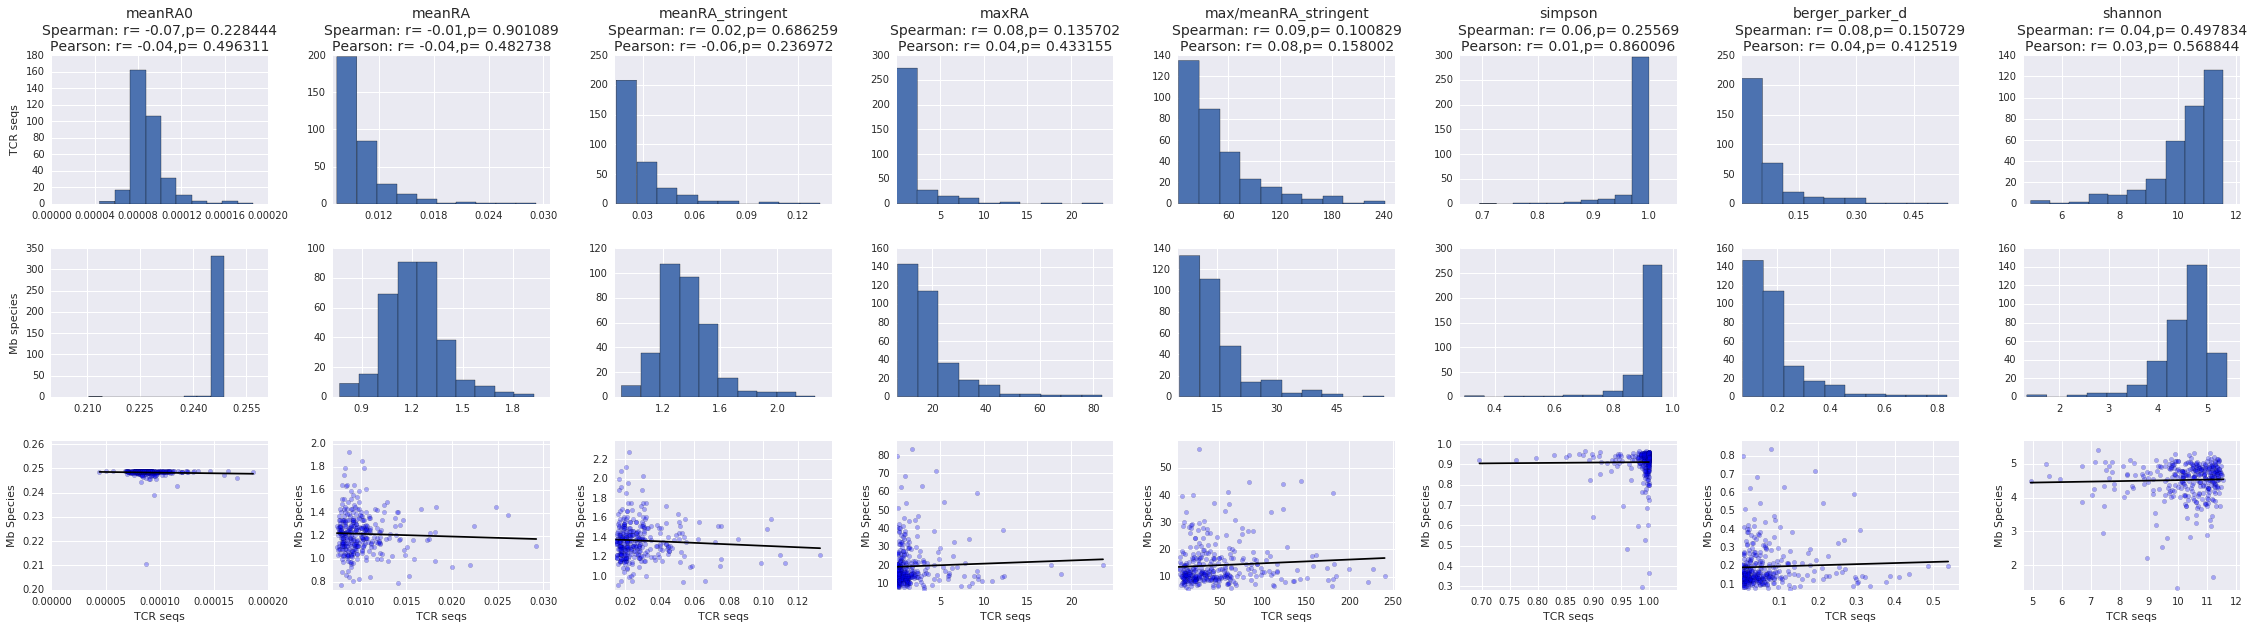

In [19]:
nPlots=len(seqFeatureDF3.columns)

hsize=4*nPlots
vsize=9
fig, axes=plt.subplots(nrows=3, ncols=nPlots,figsize=(hsize,vsize))

for n,column in enumerate(seqFeatureDF3.columns.values):
    
    r_p, p_p = MyPearsonr(seqFeatureDF3[column], speciesFeatureDF3[column])
    r_s, p_s = MySpearmanr(seqFeatureDF3[column], speciesFeatureDF3[column])
        
        
    ax1=axes[0,n]
    seqFeatureDF3[column].hist(ax=ax1)
    ax1.set_title('%s\nSpearman: r= %s,p= %s\nPearson: r= %s,p= %s' % (column,round(r_s, 2), round(p_s, 6),
                   round(r_p, 2), round(p_p, 6)),fontsize=14)
    ax1.xaxis.set_major_locator(plt.MaxNLocator(5))
#     for tick in ax1.get_xticklabels():
#         tick.set_rotation(90)
    xmax1 = round(np.max(seqFeatureDF3[column]) * 1.05, 4)
    xmin1 = round(np.min(seqFeatureDF3[column]) * 0.95, 4)
    ax1.set_xlim(xmin1,xmax1)
   
    
    ax2=axes[1,n]
    speciesFeatureDF3[column].hist(ax=ax2)
    ax2.xaxis.set_major_locator(plt.MaxNLocator(5))
    xmax2 = round(np.max(speciesFeatureDF3[column]) * 1.05, 4)
    xmin2 = round(np.min(speciesFeatureDF3[column]) * 0.95, 4)
    ax2.set_xlim(xmin2,xmax2)
    
    
    ax3=axes[2,n]
    ax3.scatter(seqFeatureDF3[column],speciesFeatureDF3[column],alpha=0.3)
    ax3.set_xlabel('TCR seqs')
    ax3.set_ylabel('Mb Species')
    plot_bestFitLine(seqFeatureDF3[column], speciesFeatureDF3[column], ax=ax3, color='black')
    ax3.set_xlim(xmin1,xmax1)
    ax3.set_ylim(xmin2,xmax2)
    
    
    if n==0:
        ax1.set_ylabel('TCR seqs')
        ax2.set_ylabel('Mb species')
        
fig.subplots_adjust(left=0.04, bottom=None, right=0.99, top=0.95,
    wspace=0.3, hspace=0.3)

    
plt.show()
    



In [20]:
file1='%s/TCR_mb_results/divCorrTCR_MB_dfs/libPrepMethodNone_minNshared2_divCorrTCRMBplot_%s_stringent%s_new' %(datasetFolder, 
                                                corrType,isStringent)
fig.savefig(file1,dpi=200)

#### repeat with sample outlier removal:

In [28]:
print len(speciesFeatureDF)
print len(seqFeatureDF)
outlierSTD=5

speciesFeatureDF4 = filter_outliers(df=speciesFeatureDF, 
                                    outlierSTD=outlierSTD, columnList=None,trim=True)
seqFeatureDF4 = filter_outliers(df=seqFeatureDF, 
                                    outlierSTD=outlierSTD, columnList=None,trim=True)

print len(speciesFeatureDF4)
print len(seqFeatureDF4)

speciesFeatureDF4=speciesFeatureDF4[speciesFeatureDF4.index.isin(list(seqFeatureDF4.index))]
seqFeatureDF4=seqFeatureDF4[seqFeatureDF4.index.isin(list(speciesFeatureDF4.index))]

speciesFeatureDF4=speciesFeatureDF4.sort_index()
seqFeatureDF4=seqFeatureDF4.sort_index()

print len(speciesFeatureDF4)
print len(seqFeatureDF4)

print speciesFeatureDF4.iloc[:5,:5]
print seqFeatureDF4.iloc[:5,:5]

print speciesFeatureDF4.iloc[-5:,:5]
print seqFeatureDF4.iloc[-5:,:5]

# speciesFeatureDF=speciesFeatureDF.fillna(0)
# seqFeatureDF=seqFeatureDF.fillna(0)

446
391
446
391
336
336
       nCom  nCom_stringest   meanRA0    meanRA  meanRA_stringent
BD                                                               
BD1    83.0       78.000000  0.248577  1.203949          1.280750
BD10   65.0       64.000000  0.248267  1.535437          1.559381
BD101  96.0       76.000000  0.248756  1.041666          1.314541
BD105  90.0       77.000000  0.248756  1.111112          1.297876
BD106  63.0       54.652518  0.248756  1.554333          1.749109
              nCom  nCom_stringest   meanRA0    meanRA  meanRA_stringent
BD                                                                      
BD1    2831.000000           308.0  0.000082  0.008042          0.019307
BD10   2705.000000           512.0  0.000094  0.009641          0.022383
BD101  1755.986618           276.0  0.000060  0.009596          0.024082
BD105  2513.000000           499.0  0.000085  0.009341          0.020134
BD106  2734.000000           464.0  0.000089  0.008976          0.020273
   

In [29]:
# corrType='pearson'
corrType='Spearman'


print 'calculating correlation between TCR and MB...'
divCorrTCR_MB = pd.DataFrame()
for n, column in enumerate(seqFeatureDF4.columns):
    if corrType=='pearson':
        r, p = MyPearsonr(seqFeatureDF4[column], speciesFeatureDF4[column])
    else:
        r, p = MySpearmanr(seqFeatureDF4[column], speciesFeatureDF4[column])
#     print corrType
    print column, r, p
    divCorrTCR_MB.loc[n, 'column'] = column
    divCorrTCR_MB.loc[n, 'r'] = r
    divCorrTCR_MB.loc[n, 'p'] = p

# ## save diversity correlation df....
minP = round(divCorrTCR_MB['p'].min(), 3)
print 'the best p-value is %s' % minP

file1='%s/TCR_mb_results/divCorrTCR_MB_dfs/libPrepMethodNone_minNshared2_divCorrTCR_MB_%s_std%s.xlsx' %(datasetFolder, corrType,outlierSTD)
divCorrTCR_MB.to_excel(file1)

calculating correlation between TCR and MB...
nCom -0.025888193447646278 0.6363207278203609
nCom_stringest 0.01964385636272731 0.7197667206588263
meanRA0 -0.06596096006086559 0.22785904832082918
meanRA -0.007184998080247768 0.8956059612796936
meanRA_stringent 0.022964581389863174 0.6748987332684181
meanLogRA0 -0.06497899326531319 0.2348721525988246
maxRA 0.08055261849464124 0.140630636549177
maxRA_stringent 0.08055261849464124 0.140630636549177
max/meanRA 0.08496900973781006 0.12006141641433242
max/meanRA0 0.08496900973781006 0.12006141641433242
max/meanRA_stringent 0.08768413441990636 0.10863063580124845
simpson 0.06273576464135487 0.251460135217128
simpson_stringent 0.04101925554026889 0.4536108419904902
berger_parker_d 0.07910793829945181 0.1479145535990564
berger_parker_d_stringent 0.0630574980686671 0.24903229257829548
shannon 0.03628531256403299 0.5074199443453689
shannon_stringent 0.01777108960301373 0.7455132411451231
the best p-value is 0.109


In [ ]:
corrType='pearson'
# corrType='Spearman'


print 'calculating correlation between TCR and MB...'
divCorrTCR_MB = pd.DataFrame()
for n, column in enumerate(seqFeatureDF4.columns):
    if corrType=='pearson':
        r, p = MyPearsonr(seqFeatureDF4[column], speciesFeatureDF4[column])
    else:
        r, p = MySpearmanr(seqFeatureDF4[column], speciesFeatureDF4[column])
#     print corrType
    print column, r, p
    divCorrTCR_MB.loc[n, 'column'] = column
    divCorrTCR_MB.loc[n, 'r'] = r
    divCorrTCR_MB.loc[n, 'p'] = p

# ## save diversity correlation df....
minP = round(divCorrTCR_MB['p'].min(), 3)
print 'the best p-value is %s' % minP

file1='%s/TCR_mb_results/divCorrTCR_MB_dfs/libPrepMethodNone_minNshared2_divCorrTCR_MB_%s_std%s.xlsx' %(datasetFolder, corrType,outlierSTD)
divCorrTCR_MB.to_excel(file1)

In [25]:
toPlotList=['meanRA0','meanRA','meanRA_stringent','maxRA','max/meanRA_stringent','simpson','berger_parker_d','shannon']

In [26]:
seqFeatureDF5=seqFeatureDF4[toPlotList]
speciesFeatureDF5=speciesFeatureDF4[toPlotList]

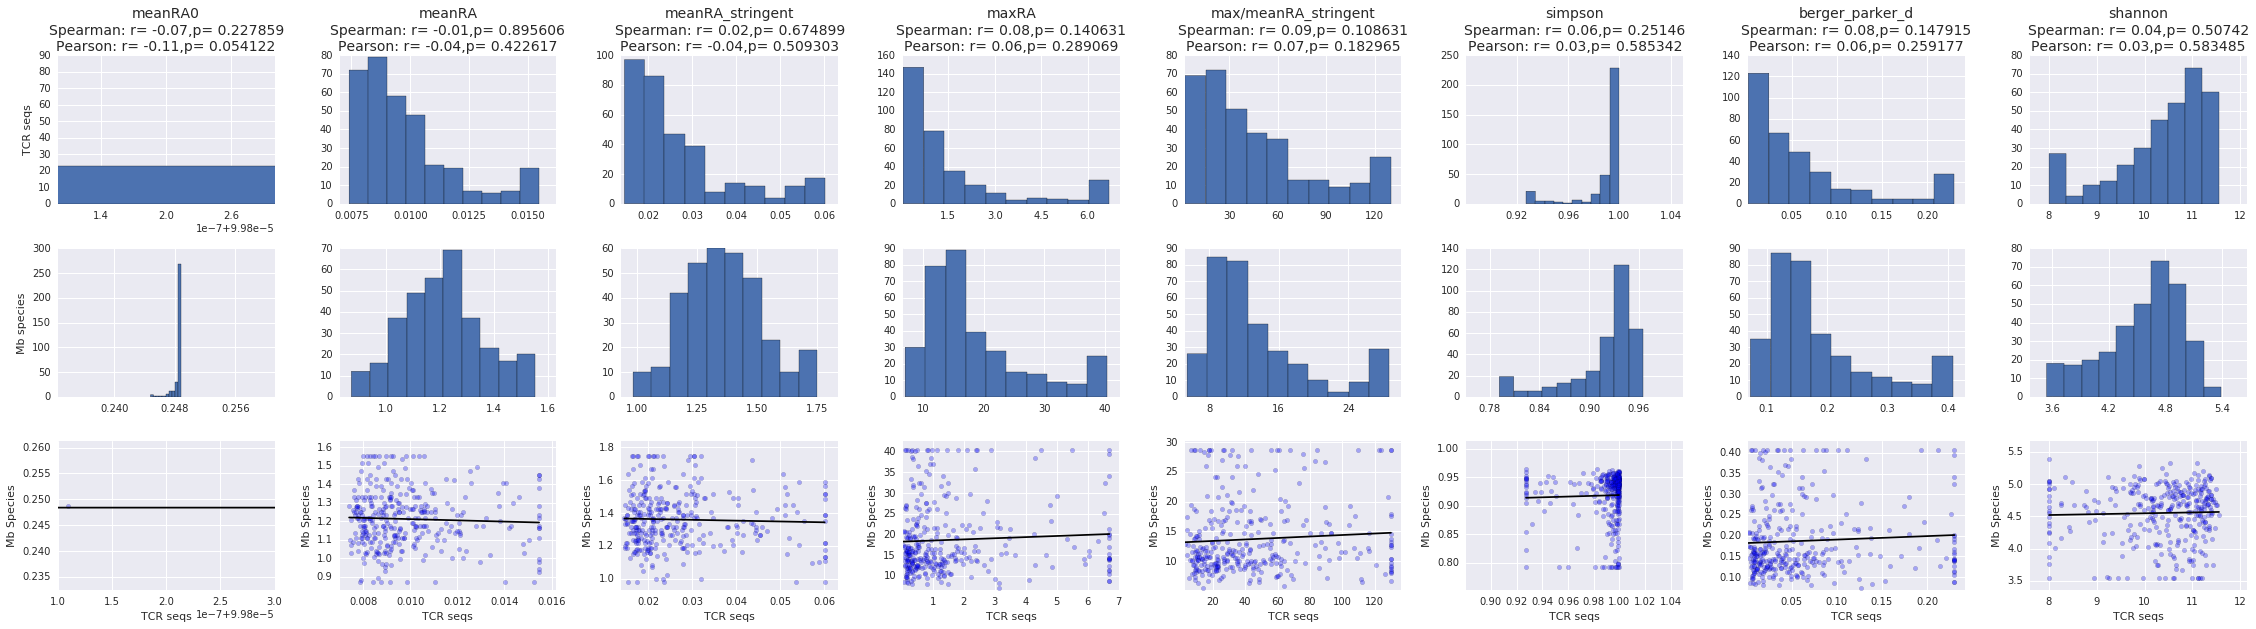

In [32]:
nPlots=len(seqFeatureDF5.columns)



hsize=4*nPlots
vsize=9
fig, axes=plt.subplots(nrows=3, ncols=nPlots,figsize=(hsize,vsize))

for n,column in enumerate(seqFeatureDF5.columns.values):
    
    r_p, p_p = MyPearsonr(seqFeatureDF5[column], speciesFeatureDF5[column])
    r_s, p_s = MySpearmanr(seqFeatureDF5[column], speciesFeatureDF5[column])
        
        
    ax1=axes[0,n]
    seqFeatureDF5[column].hist(ax=ax1)
    ax1.set_title('%s\nSpearman: r= %s,p= %s\nPearson: r= %s,p= %s' % (column,round(r_s, 2), round(p_s, 6),
                   round(r_p, 2), round(p_p, 6)),fontsize=14)
    ax1.xaxis.set_major_locator(plt.MaxNLocator(5))
#     for tick in ax1.get_xticklabels():
#         tick.set_rotation(90)
    xmax1 = round(np.max(seqFeatureDF5[column]) * 1.05, 4)
    xmin1 = round(np.min(seqFeatureDF5[column]) * 0.95, 4)
    ax1.set_xlim(xmin1,xmax1)
   
    
    ax2=axes[1,n]
    speciesFeatureDF5[column].hist(ax=ax2)
    ax2.xaxis.set_major_locator(plt.MaxNLocator(5))
    xmax2 = round(np.max(speciesFeatureDF5[column]) * 1.05, 4)
    xmin2 = round(np.min(speciesFeatureDF5[column]) * 0.95, 4)
    ax2.set_xlim(xmin2,xmax2)
    
    
    ax3=axes[2,n]
    ax3.scatter(seqFeatureDF5[column],speciesFeatureDF5[column],alpha=0.3)
    ax3.set_xlabel('TCR seqs')
    ax3.set_ylabel('Mb Species')
    plot_bestFitLine(seqFeatureDF5[column], speciesFeatureDF5[column], ax=ax3, color='black')
    ax3.set_xlim(xmin1,xmax1)
    ax3.set_ylim(xmin2,xmax2)
    
    
    if n==0:
        ax1.set_ylabel('TCR seqs')
        ax2.set_ylabel('Mb species')
        
fig.subplots_adjust(left=0.04, bottom=None, right=0.99, top=0.95,
    wspace=0.3, hspace=0.3)

    
plt.show()
    



#### look at specific cases:

In [ ]:
seqFeatureDF2.sort_values(by='meanRA',ascending=False)

#### filter outlier in RA data: